#**Exercício - Aula 3**

Como já samemos, a base de dados de "produto" [1] foi utilizada para modelos de classificação supervisionados e sabemos qual foi a configuração que gerou um bom resultado. Que tal aplicarmos essas técnicas de pré-processamento que gerou um bom modelo e compararmos? Faça um teste de análise de tópicos com 4 tópicos conse as seguintes configurações:

*   Remover registros com valores nulos;
*   Contatenar as colunas de nome e descrição;
*   Aplicar lematização em verbos;
*   Amostra de 30% para teste e random_state = 42;
*   Vetorização de contagem dos termos em unigramas removendo stopwords (NLTK).

[1] https://dados-ml-pln.s3-sa-east-1.amazonaws.com/produtos.csv


In [ ]:
!python -m spacy download pt_core_news_sm

In [3]:
import pandas as pd

df = pd.read_csv("https://dados-ml-pln.s3-sa-east-1.amazonaws.com/produtos.csv", delimiter=";", encoding='utf-8')

df.dropna(inplace=True)

df["texto"] = df['nome'] + " " + df['descricao']

df.describe()

,nome,descricao,categoria,texto
count,2916,2916,2916,2916
unique,2584,2460,4,2646
top,Boneco Dragon Ball Z Son Gokou,JOGO ORIGINAL. NOVO. LACRADO. PRONTA ENTREGA. ...,livro,Boneco Dragon Ball Z Son Gokou Produto novo
freq,20,39,838,20


In [4]:
import spacy
nlp = spacy.load('pt_core_news_sm')

def lemmatizer_verbs(text):
  sent = []
  doc = nlp(text)
  for word in doc:
      if word.pos_ == "VERB":
          sent.append(word.lemma_)
      else:
          sent.append(word.text)
  return " ".join(sent)

df['text_lemma_verbs'] = df.texto.apply(lemmatizer_verbs)

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,
      test_size = 0.3,
      random_state = 42
  )

In [6]:
import nltk
nltk.download('stopwords')

# stopwords NLTK
stops = nltk.corpus.stopwords.words('portuguese')

from sklearn.feature_extraction.text import CountVectorizer

# verorização
vect = CountVectorizer(ngram_range=(1,1), stop_words=stops)
vect.fit(df_train.text_lemma_verbs)
text_vect_train = vect.transform(df_train.text_lemma_verbs)

from sklearn.decomposition import LatentDirichletAllocation

# modelo
LDA = LatentDirichletAllocation(n_components=4,random_state=42)
LDA.fit(text_vect_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


LatentDirichletAllocation(n_components=4, random_state=42)

In [7]:
# top palavras dos tópicos
terms = vect.get_feature_names_out()

for index, topic in enumerate(LDA.components_):
    terms_comp = zip(terms, topic)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
    print("THE TOP 15 WORDS FOR TOPIC # "+str(index)+": ")
    #print(sorted_terms)
    print([t[0] for t in sorted_terms])
    print('\n')

THE TOP 15 WORDS FOR TOPIC # 0: 
['pincel', 'cm', 'maquiagem', 'kit', 'cores', '01', 'maleta', 'profissional', 'base', 'produto', 'matte', 'sombra', 'cor', 'cílios', 'ruby']


THE TOP 15 WORDS FOR TOPIC # 1: 
['mercado', 'produto', 'prazo', 'pagamento', 'produtos', 'entrega', 'envio', 'enviar', 'dias', 'frete', 'anúncio', 'comprar', 'cliente', 'gta', 'após']


THE TOP 15 WORDS FOR TOPIC # 2: 
['produto', 'edição', 'livro', 'páginas', 'ter', 'poder', 'mundo', 'novo', 'vida', 'anos', 'história', '00', 'capa', 'origem', 'livros']


THE TOP 15 WORDS FOR TOPIC # 3: 
['jogo', 'compra', 'frete', 'digital', 'the', 'vendedor', 'ter', 'retirar', 'original', 'poder', 'produto', 'jogar', 'of', 'online', 'envio']




In [8]:
{'maquiagem': 0, 'game': 1, 'livro': 2, 'brinquedo': 3 }

{'maquiagem': 0, 'game': 1, 'livro': 2, 'brinquedo': 3}

In [9]:
text_vect_test = vect.transform(df_test.text_lemma_verbs)
results = LDA.transform(text_vect_test)

df_test['topico'] = results.argmax(axis=1)

df_test.head()

,nome,descricao,categoria,texto,text_lemma_verbs,topico
2700,Estojo Duo Iluminador E Bronzer Belle Angel M...,DUO ILUMINADOR E BRONZER BELLE ANGEL - B025O D...,maquiagem,Estojo Duo Iluminador E Bronzer Belle Angel M...,Estojo Duo Iluminador E Bronzer Belle Angel ...,0
1297,Patrulha Canina Carrinhos De Fricção 6 Person...,Kit carrinhos da Patrulha canina Tamanho: Cerc...,brinquedo,Patrulha Canina Carrinhos De Fricção 6 Person...,Patrulha Canina Carrinhos De Fricção 6 Perso...,1
3162,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,#Nossos produtos são NOVOS e 100% ORIGINAIS# ...,game,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,Pokemon Ultra Moon Nintendo 3ds Midia Fisica...,2
2895,Kite Pincel 12 Unidade,esta alta qualidade Punho de madeira Escova Co...,maquiagem,Kite Pincel 12 Unidade esta alta qualidade ...,Kite Pincel 12 Unidade esta alta qualida...,0
2226,Maleta Grande P/ Maquiagem Profissional Rodin...,FOTOS REAIS DO PRODUTO - ENVIAMOS SUA MALETA C...,maquiagem,Maleta Grande P/ Maquiagem Profissional Rodin...,Maleta Grande P/ Maquiagem Profissional Rodi...,0


In [12]:
import numpy as np

df_test['categ_cod'] = df_test.categoria.map(
    #{'livro': 0, 'brinquedo': 1, 'maquiagem': 2, 'game': 3 }
    {'maquiagem': 0, 'brinquedo': 1, 'livro': 2, 'game': 3 }
    )

df_test.head()

,nome,descricao,categoria,texto,text_lemma_verbs,topico,categ_cod
2700,Estojo Duo Iluminador E Bronzer Belle Angel M...,DUO ILUMINADOR E BRONZER BELLE ANGEL - B025O D...,maquiagem,Estojo Duo Iluminador E Bronzer Belle Angel M...,Estojo Duo Iluminador E Bronzer Belle Angel ...,0,0
1297,Patrulha Canina Carrinhos De Fricção 6 Person...,Kit carrinhos da Patrulha canina Tamanho: Cerc...,brinquedo,Patrulha Canina Carrinhos De Fricção 6 Person...,Patrulha Canina Carrinhos De Fricção 6 Perso...,1,1
3162,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,#Nossos produtos são NOVOS e 100% ORIGINAIS# ...,game,Pokemon Ultra Moon Nintendo 3ds Midia Fisica ...,Pokemon Ultra Moon Nintendo 3ds Midia Fisica...,2,3
2895,Kite Pincel 12 Unidade,esta alta qualidade Punho de madeira Escova Co...,maquiagem,Kite Pincel 12 Unidade esta alta qualidade ...,Kite Pincel 12 Unidade esta alta qualida...,0,0
2226,Maleta Grande P/ Maquiagem Profissional Rodin...,FOTOS REAIS DO PRODUTO - ENVIAMOS SUA MALETA C...,maquiagem,Maleta Grande P/ Maquiagem Profissional Rodin...,Maleta Grande P/ Maquiagem Profissional Rodi...,0,0


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(df_test.categ_cod, df_test.topico))

0.7657142857142857


<Axes: >

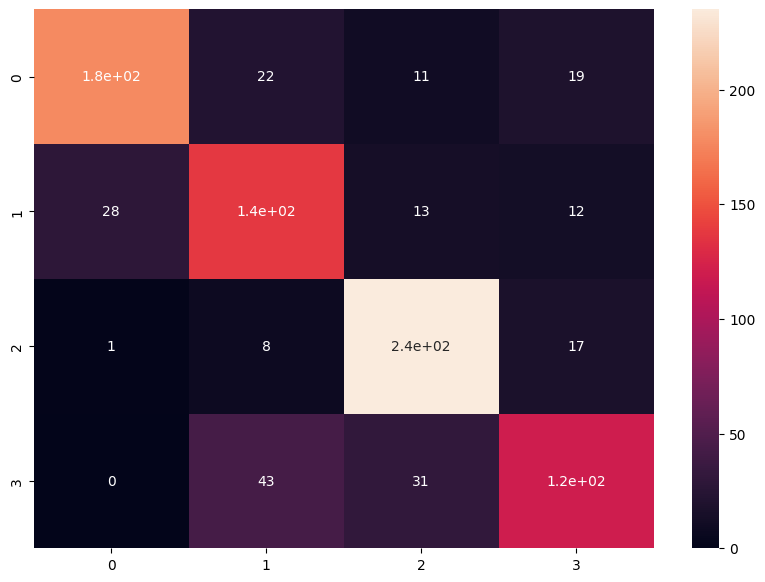

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(df_test.categ_cod, df_test.topico)

df_cm = pd.DataFrame(matrix, index=list('0123'),
                  columns=list('0123'))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)